In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vehicle-reidentification-in-context:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1390784%2F2305907%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T123015Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D51c7809856fb4b6acc89ee788be0ef4a99e946b1fae0f4d0003ea8a8516989372b282bbafa5ef5082625e0cd81c811926235ad72023290e2815d93bd951c4acf5cbfb4fa5c6ad5474340b6da17421c97d7dda42f9c98048d18c52aa592b2adb0ae012461e5c66e7af4e7dba482622bbb880732c2b25c3a38772dfd5dcae0b0f1c3f5a938e474c4828ec36ad0b70fe5c441dc6c877cbf9cc5e8c6377645e63f506961ab7495b3c9948d7a6f4f41918dc04c075fa255c62f88e3e3eb19d1c5393a657323f4ab8086455556e3b3aadc992342141b52a2c9a23906f23f799fc483e880e5e04a5a2d09fe3ebde082449a0e1abbe80c17bf0a98fc4b775c1aa9c09a7e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 119847161 bytes downloaded
Downloaded and uncompressed: vehicle-reidentification-in-context
Data source import complete.


In [ ]:
!pip install kecam
#!pip install -U keras-cv-attention-models
#!pip install -U git+https://github.com/leondgarse/keras_cv_attention_models -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.0/796.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.1 MB/s eta 0:00:00


In [ ]:
from IPython.display import Image, clear_output  # to display images
import os
import shutil
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
#from kaggle_datasets import KaggleDatasets

def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

COMPETITION_NAME = "vehicle-reidentification-in-context"
strategy = auto_select_accelerator()
BATCH_SIZE = 256
# GCS_DS_PATH = KaggleDatasets().get_gcs_path(COMPETITION_NAME)
print('BATCH_SIZE:', BATCH_SIZE)
# print(GCS_DS_PATH)

Running on TPU: 
Running on 8 replicas
BATCH_SIZE: 256


In [ ]:
SEED = 1024

def seedBasic(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# tensorflow random seed
import tensorflow as tf
def seedTF(seed=SEED):
    tf.random.set_seed(seed)

# torch random seed
import torch
def seedTorch(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + tensorflow + torch
def seedEverything(seed=SEED):
    seedBasic(seed)
    seedTF(seed)
    seedTorch(seed)

seedEverything(SEED)

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
from keras_cv_attention_models import efficientnet
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Activation, Conv2D, Input, GlobalAveragePooling2D, Concatenate, InputLayer, \
ReLU, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, Softmax, Lambda, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Optimizer
from tensorflow_addons.optimizers import AdamW

im_size = 64
emb_dim = 512

def create_emb_model():
    with strategy.scope():
        base = efficientnet.EfficientNetV2B0(num_classes=0, input_shape=(im_size, im_size, 3), pretrained="imagenet21k", include_preprocessing=True)

        feature = base.output

        x = GlobalAveragePooling2D()(feature)
        x = Dropout(0.5)(x)
        x = Dense(emb_dim)(x)
        x = BatchNormalization()(x)

        model = Model(base.input, x, name="embedding")

    return model

emb_model = create_emb_model()
# emb_model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


136355412/136355412 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2-b0-21k.h5


In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ArcFace(Layer):
    def __init__(self, n_classes=10, s=30.0, m=0.50, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_labels
        self.s = s
        self.m = m
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        c = K.shape(x)[-1]
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        target_logits = tf.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)

        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

In [ ]:
import tensorflow.keras.backend as K
import math

ROT_ = 60.0
SHR_ = 1.0

HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 4.0
WSHIFT_ = 4.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies

    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])

    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')

    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)

    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero,
                               zero,            one/width_zoom, zero,
                               zero,            zero,           one])
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift,
                                zero, one,  width_shift,
                                zero, zero, one])

    return K.dot(zoom_matrix,     shift_matrix)

def transform_mat(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = im_size
    XDIM = DIM%2

    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32')
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32')

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift)

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )

    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)

    # FIND ORIGIN PIXEL VALUES
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))

    return tf.reshape(d, [DIM, DIM,3])

def batch_transform_mat(x, y):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with transform applied
    batch_size = BATCH_SIZE
    x_list = []
    for i in range(batch_size):

        x1 = transform_mat(x[i])
        x_list.append(x1)

    x = tf.stack(x_list, axis=0)
    return x, y

def default_augment(img):
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_flip_left_right(img)
    # img = tf.image.rot90(img, k=tf.random.uniform([],0,4,tf.int32))

    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    img = tf.image.random_hue(img, 0.05)

    img = transform_mat(img)

    return img

def batch_default_augment(x, y):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with transform applied
    batch_size = BATCH_SIZE
    x_list = []
    for i in range(batch_size):

        x1 = default_augment(x[i])
        x_list.append(x1)

    x = tf.stack(x_list, axis=0)
    return x, y

def batch_cutmix(images, labels, PROBABILITY=1.0, batch_size=0):

    DIM = im_size
    CLASSES = n_labels

    if batch_size == 0:
        batch_size = BATCH_SIZE

    # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
    # This is a tensor containing 0 or 1 -- 0: no cutmix.
    # shape = [batch_size]
    do_cutmix = tf.cast(tf.random.uniform([batch_size], 0, 1) <= PROBABILITY, tf.int32)

    # Choose random images in the batch for cutmix
    # shape = [batch_size]
    new_image_indices = tf.cast(tf.random.uniform([batch_size], 0, batch_size), tf.int32)

    # Choose random location in the original image to put the new images
    # shape = [batch_size]
    new_x = tf.cast(tf.random.uniform([batch_size], 0, DIM), tf.int32)
    new_y = tf.cast(tf.random.uniform([batch_size], 0, DIM), tf.int32)

    # Random width for new images, shape = [batch_size]
    b = tf.random.uniform([batch_size], 0, 1) # this is beta dist with alpha=1.0
    new_width = tf.cast(DIM * tf.math.sqrt(1-b), tf.int32) * do_cutmix

    # shape = [batch_size]
    new_y0 = tf.math.maximum(0, new_y - new_width // 2)
    new_y1 = tf.math.minimum(DIM, new_y + new_width // 2)
    new_x0 = tf.math.maximum(0, new_x - new_width // 2)
    new_x1 = tf.math.minimum(DIM, new_x + new_width // 2)

    # shape = [batch_size, DIM]
    target = tf.broadcast_to(tf.range(DIM), shape=(batch_size, DIM))

    # shape = [batch_size, DIM]
    mask_y = tf.math.logical_and(new_y0[:, tf.newaxis] <= target, target <= new_y1[:, tf.newaxis])

    # shape = [batch_size, DIM]
    mask_x = tf.math.logical_and(new_x0[:, tf.newaxis] <= target, target <= new_x1[:, tf.newaxis])

    # shape = [batch_size, DIM, DIM]
    mask = tf.cast(tf.math.logical_and(mask_y[:, :, tf.newaxis], mask_x[:, tf.newaxis, :]), tf.float32)

    # All components are of shape [batch_size, DIM, DIM, 3]
    new_images =  images * tf.broadcast_to(1 - mask[:, :, :, tf.newaxis], [batch_size, DIM, DIM, 3]) + \
                    tf.gather(images, new_image_indices) * tf.broadcast_to(mask[:, :, :, tf.newaxis], [batch_size, DIM, DIM, 3])

    a = tf.cast(new_width ** 2 / DIM ** 2, tf.float32)

    # Make labels
    if len(labels.shape) == 1:
        labels = tf.one_hot(labels, CLASSES)

    new_labels =  (1-a)[:, tf.newaxis] * labels + a[:, tf.newaxis] * tf.gather(labels, new_image_indices)

    return new_images, new_labels


def batch_mixup(images, labels, PROBABILITY=1.0, batch_size=0):

    DIM = im_size
    CLASSES = n_labels

    if batch_size == 0:
        batch_size = BATCH_SIZE

    # Do `batch_mixup` with a probability = `PROBABILITY`
    # This is a tensor containing 0 or 1 -- 0: no mixup.
    # shape = [batch_size]
    do_mixup = tf.cast(tf.random.uniform([batch_size], 0, 1) <= PROBABILITY, tf.int32)

    # Choose random images in the batch for cutmix
    # shape = [batch_size]
    new_image_indices = tf.cast(tf.random.uniform([batch_size], 0, batch_size), tf.int32)

    # ratio of importance of the 2 images to be mixed up
    # shape = [batch_size]
    a = tf.random.uniform([batch_size], 0, 1) * tf.cast(do_mixup, tf.float32)  # this is beta dist with alpha=1.0

    # The second part corresponds to the images to be added to the original images `images`.
    new_images =  (1-a)[:, tf.newaxis, tf.newaxis, tf.newaxis] * images + a[:, tf.newaxis, tf.newaxis, tf.newaxis] * tf.gather(images, new_image_indices)

    # Make labels
    if len(labels.shape) == 1:
        labels = tf.one_hot(labels, CLASSES)
    new_labels =  (1-a)[:, tf.newaxis] * labels + a[:, tf.newaxis] * tf.gather(labels, new_image_indices)

    return new_images, new_labels


def get_batch_rotation_matrix(angles, batch_size=0):
    """Returns a tf.Tensor of shape (batch_size, 3, 3) with each element along the 1st axis being
       an image rotation matrix (which transforms indicies).

    Args:
        angles: 1-D Tensor with shape [batch_size].

    Returns:
        A 3-D Tensor with shape [batch_size, 3, 3].
    """

    if batch_size == 0:
        batch_size = BATCH_SIZE

    # CONVERT DEGREES TO RADIANS
    angles = tf.constant(math.pi) * angles / 180.0

    # shape = (batch_size,)
    one = tf.ones_like(angles, dtype=tf.float32)
    zero = tf.zeros_like(angles, dtype=tf.float32)

    # ROTATION MATRIX
    c1 = tf.math.cos(angles) # shape = (batch_size,)
    s1 = tf.math.sin(angles) # shape = (batch_size,)

    # Intermediate matrix for rotation, shape = (9, batch_size)
    rotation_matrix_temp = tf.stack([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    rotation_matrix_temp = tf.transpose(rotation_matrix_temp)
    # Fianl rotation matrix, shape = (batch_size, 3, 3)
    rotation_matrix = tf.reshape(rotation_matrix_temp, shape=(batch_size, 3, 3))

    return rotation_matrix


def batch_random_rotate(images, max_angles, batch_size=0):
    """Returns a tf.Tensor of the same shape as `images`, represented a batch of randomly transformed images.

    Args:
        images: 4-D Tensor with shape (batch_size, width, hight, depth).
            Currently, `depth` can only be 3.

    Returns:
        A 4-D Tensor with the same shape as `images`.
    """

    # input `images`: a batch of images [batch_size, dim, dim, 3]
    # output: images randomly rotated, sheared, zoomed, and shifted
    DIM = images.shape[1]
    XDIM = DIM % 2  # fix for size 331

    if batch_size == 0:
        batch_size = BATCH_SIZE

    angles = max_angles * tf.random.normal([batch_size], dtype='float32')


    # GET TRANSFORMATION MATRIX
    # shape = (batch_size, 3, 3)
    m = get_batch_rotation_matrix(angles, batch_size)

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat(tf.range(DIM // 2, -DIM // 2, -1), DIM)  # shape = (DIM * DIM,)
    y = tf.tile(tf.range(-DIM // 2, DIM // 2), [DIM])  # shape = (DIM * DIM,)
    z = tf.ones([DIM * DIM], dtype='int32')  # shape = (DIM * DIM,)
    idx = tf.stack([x, y, z])  # shape = (3, DIM * DIM)

    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tf.linalg.matmul(m, tf.cast(idx, dtype='float32'))  # shape = (batch_size, 3, DIM ** 2)
    idx2 = K.cast(idx2, dtype='int32')  # shape = (batch_size, 3, DIM ** 2)
    idx2 = K.clip(idx2, -DIM // 2 + XDIM + 1, DIM // 2)  # shape = (batch_size, 3, DIM ** 2)

    # FIND ORIGIN PIXEL VALUES
    # shape = (batch_size, 2, DIM ** 2)
    idx3 = tf.stack([DIM // 2 - idx2[:, 0, ], DIM // 2 - 1 + idx2[:, 1, ]], axis=1)

    # shape = (batch_size, DIM ** 2, 3)
    d = tf.gather_nd(images, tf.transpose(idx3, perm=[0, 2, 1]), batch_dims=1)

    # shape = (batch_size, DIM, DIM, 3)
    new_images = tf.reshape(d, (batch_size, DIM, DIM, 3))

    return new_images


def batch_get_grid_mask(d1, d2, ratio=0.5, max_angle=90, batch_size=0):

    # ratio: the ratio of black region

    DIM = im_size
    CLASSES = n_labels

    if batch_size == 0:
        batch_size = BATCH_SIZE

    # Length of diagonal
    hh = tf.cast((tf.math.ceil(tf.math.sqrt(2.0) * DIM)), tf.int64)
    hh = hh + tf.math.floormod(hh, 2)

    # We look squares of size dxd inside each image
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int64)

    # Inside each square of size dxd, we mask a square of size LxL (L <= d)
    l = tf.cast(tf.cast(d, tf.float32) * ratio + 0.5, tf.int64)

    lower_limit = -1
    upper_limit = tf.math.floordiv(hh, d) + 1
    indices = tf.range(lower_limit, upper_limit)  # shape = [upper_limit + 1]

    # The 1st component has shape [upper_limit + 1, 1]
    # The 2nd component has shae [1: L]
    # The addition has shape [upper_limit + 1: L]
    # The final output has sahpe [upper_limit + 1 * L]
    ranges = tf.reshape((d * indices)[:, tf.newaxis] + tf.range(l, dtype=tf.int64)[tf.newaxis, :], shape=[-1])
    shift = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int64)

    ranges = shift + ranges

    clip_mask = tf.logical_or(ranges < 0 , ranges > hh - 1)
    ranges = tf.boolean_mask(ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(ranges)), tf.int64)])

    ranges = tf.repeat(ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(ranges), [hh, hh])

    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = batch_random_rotate(tf.broadcast_to(mask[tf.newaxis, :, :, :], shape=[batch_size, mask.shape[0], mask.shape[1], 3]), max_angle, batch_size)

    mask = tf.image.crop_to_bounding_box(mask, int((hh - DIM) // 2), int((hh - DIM) // 2), int(tf.cast(DIM, dtype=tf.int64)), int(tf.cast(DIM, dtype=tf.int64)))

    return mask


def batch_grid_mask(images, labels, batch_size=0):

    if batch_size == 0:
        batch_size = BATCH_SIZE

    # d1, d2 determined the width of the grid
    d1 = 35
    d2 = d1 + 1 + tf.cast(35 * tf.random.uniform(shape=[]), dtype=tf.int64)
    ratio = 0.25 + 0.25 * tf.random.uniform(shape=[])
    max_angle = 90

    mask = batch_get_grid_mask(d1, d2, ratio, max_angle, batch_size)

    return images * tf.cast(mask, tf.float32), labels


def cutout(image, PROBABILITY = 1.0, CT = 6, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed

    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE

    DIM = im_size

    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image

    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]

        two = tf.zeros([yb-ya,xb-xa,3])

        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)

    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR
    image = tf.reshape(image,[DIM,DIM,3])
    return image


def batch_cutout(x, y):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with transform applied
    batch_size = BATCH_SIZE
    x_list = []
    for i in range(batch_size):

        x1 = cutout(x[i])
        x_list.append(x1)

    x = tf.stack(x_list, axis=0)
    return x, y


def BatchAdvAugment(imagesT, labelsT):
    images, labels = batch_default_augment(imagesT, labelsT)

    P = tf.random.uniform([],0,3,tf.int32)

#     if P == 0:
#         return batch_mixup(images, labels)

    if P == 0:
        return batch_cutout(images, labels)

#     if P == 2:
#         return batch_cutmix(images, labels)

    if P == 1:
        return batch_grid_mask(images, labels)

    return images, labels

In [ ]:
# format flow from directory

route = '../input/vehicle-reidentification-in-context/vric/'

X_path = []
Y_path = []

all_class = sorted(os.listdir(route))
n_labels = len(all_class)

for cl in all_class:
    path2cl = route + cl

    temp =  os.listdir(path2cl)

    X_path = X_path + temp
    Y_path = Y_path + len(temp) * [cl]

print(n_labels)
# print(all_class)

2811


In [ ]:
temp = list(zip(X_path, Y_path))
random.shuffle(temp)
resX, resY = zip(*temp)
resX, resY = list(resX), list(resY)

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold

path = '/vric/'
GCS_DS_PATH='/kaggle/input/vehicle-reidentification-in-context'
file_type = '.jpg'
VALID_SIZE = 0.1

X_train, X_valid = train_test_split(resX, test_size=VALID_SIZE, random_state=SEED)
Y_train, Y_valid = train_test_split(resY, test_size=VALID_SIZE, random_state=SEED)

X_train = [GCS_DS_PATH + path + Y_train[i] + '/' + x for i, x in enumerate(X_train)]
X_valid = [GCS_DS_PATH + path + Y_valid[i] + '/' + x for i, x in enumerate(X_valid)]

In [ ]:
Y_train = [all_class.index(x) for x in Y_train]
Y_valid = [all_class.index(x) for x in Y_valid]

Y_train = [tf.one_hot(x, n_labels) for x in Y_train]
Y_valid = [tf.one_hot(x, n_labels) for x in Y_valid]

In [ ]:
def build_decoder(with_labels=True, target_size=(256, 256), ext='png', with_inps=False, segment=False, ext2='png'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size)
#         img = tf.cast(img, tf.float32) / 255.0

        return img

    def decode_mask(path, gray=True):
        file_bytes = tf.io.read_file(path)
        if ext2 == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext2 in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.rgb_to_grayscale(img) if gray else img
        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0

        return img

    def decode_with_labels(path, label):
        return decode(path), label

    def decode_with_segments(path, path2, gray=True):
        return decode(path), decode_mask(path2, gray)

    def decode_with_inps_with_labels(path, label):
        convert = (decode(path[0]), path[1])
        return convert, label

    if with_inps:
        return decode_with_inps_with_labels

    if segment:
        return decode_with_segments

    return decode_with_labels if with_labels else decode

In [ ]:
def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augmentAdv=False, augmentAdvSeg=False,
                  repeat=True, shuffle=1024,
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    AUTO = tf.data.experimental.AUTOTUNE

    dataset_input = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset_label = tf.data.Dataset.from_tensor_slices(labels)

    dset = tf.data.Dataset.zip((dataset_input, dataset_label))
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)

    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize)

#     dset = dset.map(BatchAdvAugment, num_parallel_calls=AUTO) if augmentAdv else dset

    dset = dset.prefetch(AUTO)

    return dset

In [ ]:
train_decoder = build_decoder(with_labels=True, with_inps=True, target_size=(im_size, im_size), ext=file_type[1:])
valid_decoder = build_decoder(with_labels=True, with_inps=True, target_size=(im_size, im_size), ext=file_type[1:])

train_dataset = build_dataset(X_train, Y_train, bsize=BATCH_SIZE, decode_fn=train_decoder, augmentAdv=False)

valid_dataset = build_dataset(X_valid, Y_valid, bsize=BATCH_SIZE, decode_fn=valid_decoder,
                              repeat=False, shuffle=False, augmentAdv=False)

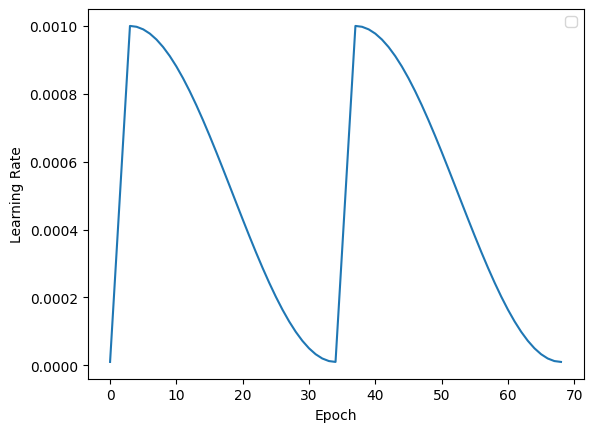

In [ ]:
def cosine_annealing_with_warmup(epochIdx):
    aMax, aMin = 1e-3, 1e-5
    warmupEpochs, stagnateEpochs, cosAnnealingEpochs = 4, 0, 30
    epochIdx = epochIdx % (warmupEpochs + stagnateEpochs + cosAnnealingEpochs)
    if(epochIdx < warmupEpochs):
        return aMin + (aMax - aMin) / (warmupEpochs - 1) * epochIdx
    else:
        epochIdx -= warmupEpochs
    if(epochIdx < stagnateEpochs):
        return aMax
    else:
        epochIdx -= stagnateEpochs
    return aMin + 0.5 * (aMax - aMin) * (1 + math.cos((epochIdx + 1) / (cosAnnealingEpochs + 1) * math.pi))

def plt_lr(step, schedulers):
    x = range(step)
    y = [schedulers(_) for _ in x]

    plt.plot(x, y)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

#35 69 103 137 171 205
epochs = 69
monitor = "val_loss"
mode = 'min'
save_path = '/kaggle/working/best_tpu.h5'
steps_per_epoch = len(X_train) // BATCH_SIZE

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    patience=10,
    restore_best_weights=True,
    mode=mode
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,
    factor=0.2,
    patience=5,
    verbose=1,
    mode=mode,
    min_lr=1e-5,
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode=mode,
    save_freq="epoch",
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(cosine_annealing_with_warmup, verbose=0)

callbacks = [checkpoint, lr_schedule]

plt_lr(epochs, cosine_annealing_with_warmup)

In [ ]:
def create_model():
    with strategy.scope():
        inp = Input(shape=(im_size, im_size, 3), name="input_1")
        label = Input(shape=(n_labels,), name="input_2")

        x = emb_model(inp)

        output = ArcFace(n_labels)([x, label])

        model = Model([inp, label], output)

        return model

model = create_model()

model.compile(optimizer=Adam(lr=1e-3),
              loss=[tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)],
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 embedding (Functional)      (None, 512)                  6577232   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 2811)]               0         []                            
                                                                                                  
 arc_face (ArcFace)          (None, 2811)                 1439232   ['embedding[0][0]',           
                                                                     'input_2[0][0]']         

In [ ]:
his = model.fit(train_dataset,
                validation_data=valid_dataset,
                epochs=epochs,
                verbose=1,
                steps_per_epoch=steps_per_epoch,
                callbacks=callbacks)

Epoch 1/69
192/192 [==============================] - ETA: 0s - loss: 22.3889 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 22.25553, saving model to /kaggle/working/best_tpu.h5
192/192 [==============================] - 91s 156ms/step - loss: 22.3889 - accuracy: 0.0000e+00 - val_loss: 22.2555 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/69
192/192 [==============================] - ETA: 0s - loss: 19.8941 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 22.25553 to 16.18333, saving model to /kaggle/working/best_tpu.h5
192/192 [==============================] - 16s 82ms/step - loss: 19.8941 - accuracy: 0.0000e+00 - val_loss: 16.1833 - val_accuracy: 7.2979e-04 - lr: 3.4000e-04
Epoch 3/69
192/192 [==============================] - ETA: 0s - loss: 14.6378 - accuracy: 0.0070
Epoch 3: val_loss improved from 16.18333 to 9.65358, saving model to /kaggle/working/best_tpu.h5
192/192 [==============================] - 16s 84ms/step - loss: 14.6378 - accuracy: 0.0070 

BEST val_loss: 1.805289387702942 at epoch: 29
BEST val_accuracy: 0.90530925989151 at epoch: 21


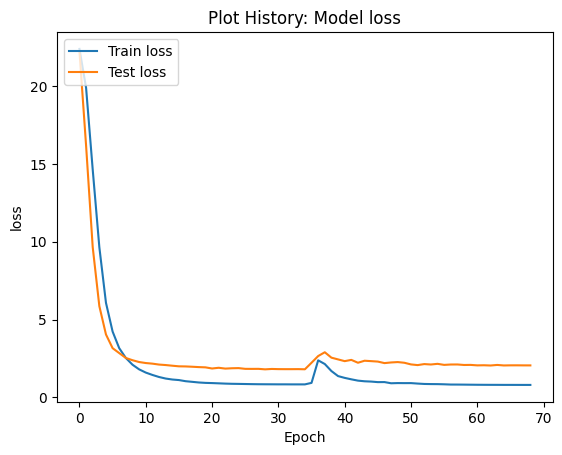

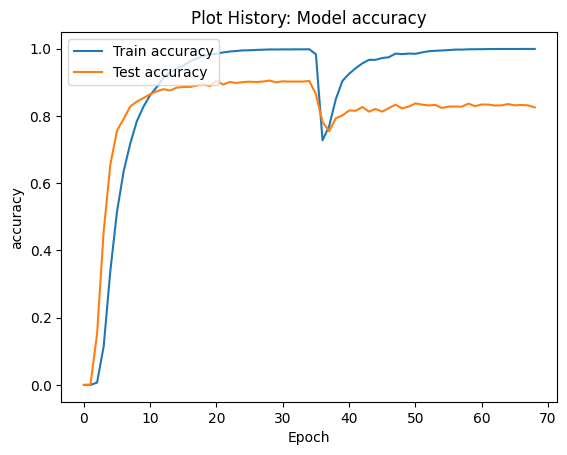

In [ ]:
m1 = 'loss'
m2 = 'accuracy'
val_m1 = 'val_' + m1
val_m2 = 'val_' + m2

print(f'BEST {val_m1}:', np.min(his.history[val_m1]), 'at epoch:', np.argmin(his.history[val_m1]) + 1)
print(f'BEST {val_m2}:', np.max(his.history[val_m2]), 'at epoch:', np.argmax(his.history[val_m2]) + 1)

plt.figure()
plt.plot(his.history[m1], label=f'train {m1}')
plt.plot(his.history[val_m1], label=f'test {m1}')
plt.title(f'Plot History: Model {m1}')
plt.ylabel(m1)
plt.xlabel('Epoch')
plt.legend([f'Train {m1}', f'Test {m1}'], loc='upper left')
plt.show()

plt.figure()
plt.plot(his.history[m2], label=f'train {m2}')
plt.plot(his.history[val_m2], label=f'test {m2}')
plt.title(f'Plot History: Model {m2}')
plt.ylabel(m2)
plt.xlabel('Epoch')
plt.legend([f'Train {m2}', f'Test {m2}'], loc='upper left')
plt.show()


In [ ]:
model_name = f'effnetv2l_{im_size}_FULL'
history_file = f'history_{model_name}'
pd.DataFrame(his.history).to_csv(f"{history_file}.csv", index=False)

In [ ]:
model.load_weights(save_path)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 embedding (Functional)      (None, 512)                  6577232   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 2811)]               0         []                            
                                                                                                  
 arc_face (ArcFace)          (None, 2811)                 1439232   ['embedding[0][0]',           
                                                                     'input_2[0][0]']         

In [ ]:
encoder = tf.keras.Sequential([
    model.get_layer('input_1'),
    model.get_layer('embedding'),
])

encoder.summary()
encoder.save('encoder.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Functional)      (None, 512)               6577232   
                                                                 
Total params: 6577232 (25.09 MB)
Trainable params: 6515600 (24.86 MB)
Non-trainable params: 61632 (240.75 KB)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2
import numpy as np

def predict(path, path2, emb_model):
    img = cv2.imread(path)
    img = img[:, :, ::-1]
    img = cv2.resize(img, (im_size, im_size))

    plt.imshow(img)

    x = np.reshape(img, (1, im_size, im_size, 3))
    p = emb_model.predict(x)[0]

    plt.figure()

    img2 = cv2.imread(path2)
    img2 = img2[:, :, ::-1]
    img2 = cv2.resize(img2, (im_size, im_size))

    plt.imshow(img2)

    x2 = np.reshape(img2, (1, im_size, im_size, 3))
    p2 = emb_model.predict(x2)[0]

    cos_similarity = np.dot(p, p2) / (np.linalg.norm(p) * np.linalg.norm(p2))

    print(cos_similarity)

1/1 [==============================] - 0s 93ms/step
1.0


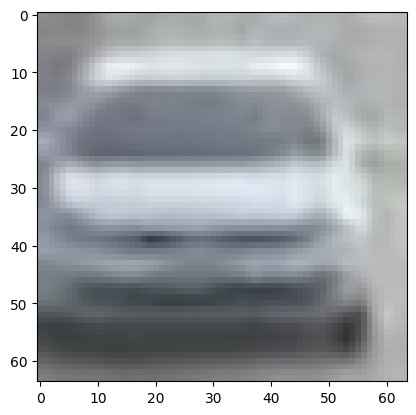

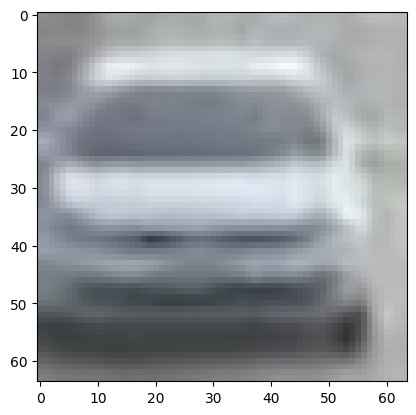

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/0/MVI_20011_004_img00011.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/0/MVI_20011_004_img00011.jpg'

predict(path, path2, encoder)

1/1 [==============================] - 0s 89ms/step
0.9779576


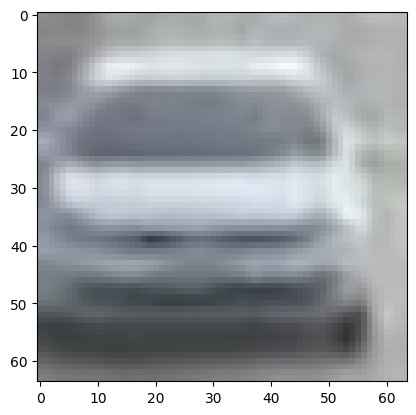

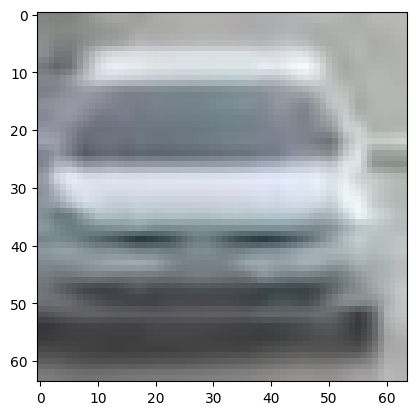

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/0/MVI_20011_004_img00011.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/0/MVI_20011_004_img00012.jpg'

predict(path, path2, encoder)

1/1 [==============================] - 0s 101ms/step
0.90545064


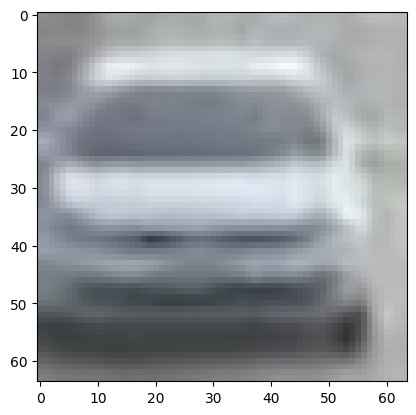

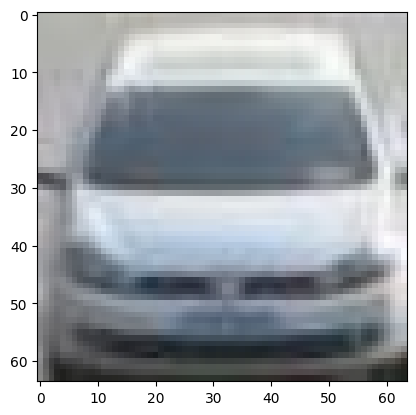

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/0/MVI_20011_004_img00011.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/0/MVI_20011_004_img00077.jpg'

predict(path, path2, encoder)

1/1 [==============================] - 0s 102ms/step
0.063394755


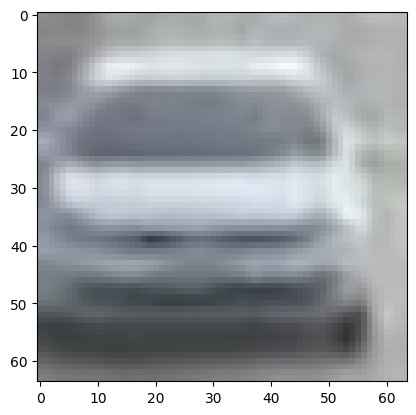

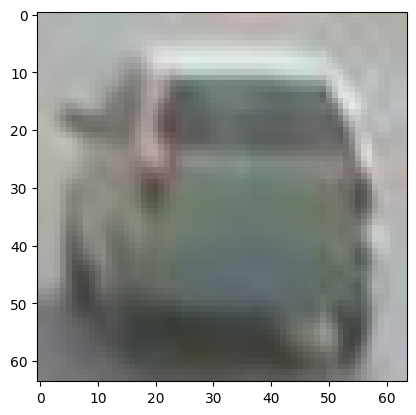

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/0/MVI_20011_004_img00011.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/1/MVI_20011_006_img00019.jpg'

predict(path, path2, encoder)

1/1 [==============================] - 0s 100ms/step
0.98317283


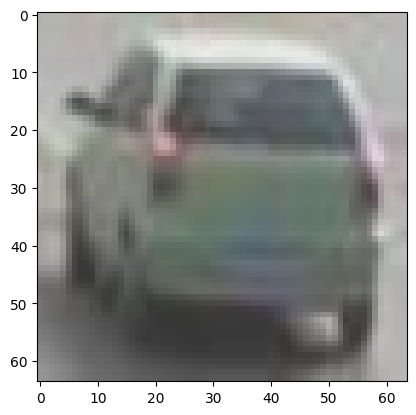

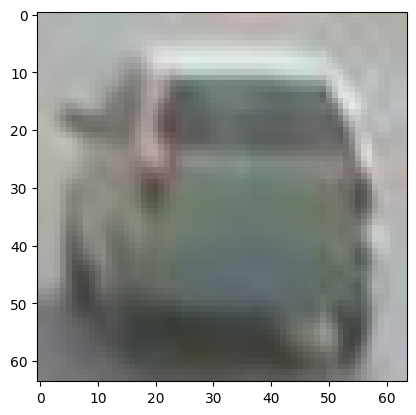

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/1/MVI_20011_006_img00002.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/1/MVI_20011_006_img00019.jpg'

predict(path, path2, encoder)

1/1 [==============================] - 0s 101ms/step
0.95279837


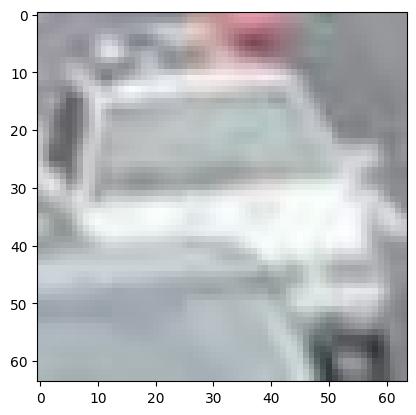

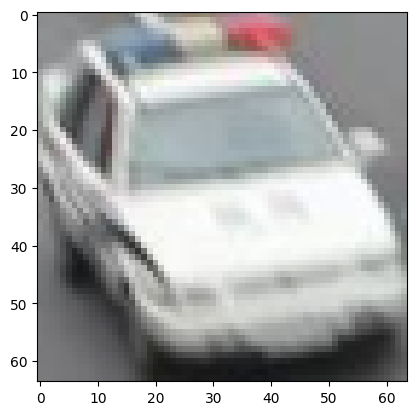

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/1002/MVI_40201_030_img00120.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/1002/MVI_40201_030_img00177.jpg'

predict(path, path2, encoder)

1/1 [==============================] - 0s 114ms/step
0.99072367


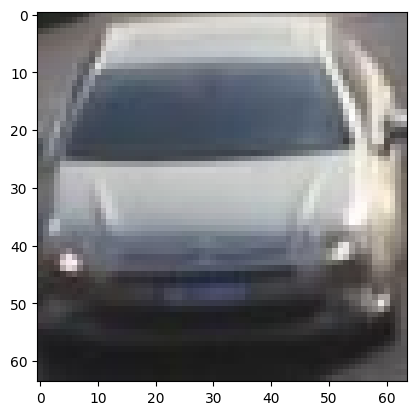

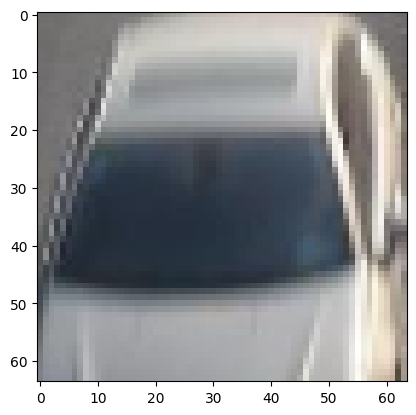

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/101/MVI_20035_031_img00013.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/101/MVI_20035_031_img00047.jpg'

predict(path, path2, encoder)

1/1 [==============================] - 0s 110ms/step
-0.032488104


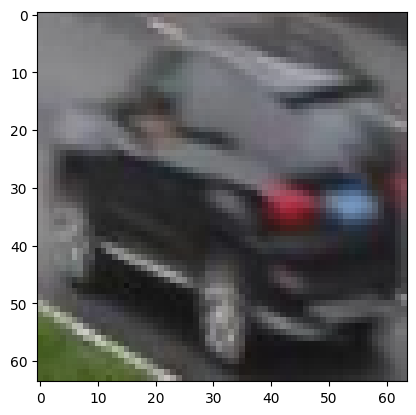

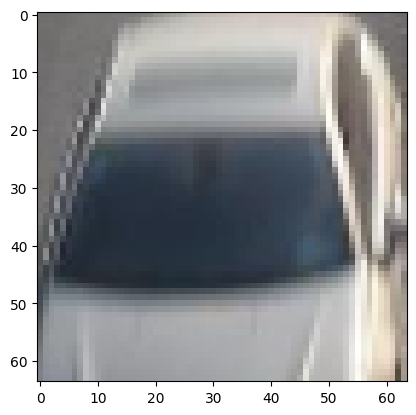

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/1020/MVI_40201_069_img00487.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/101/MVI_20035_031_img00047.jpg'

predict(path, path2, encoder)

1/1 [==============================] - 0s 108ms/step
0.949013


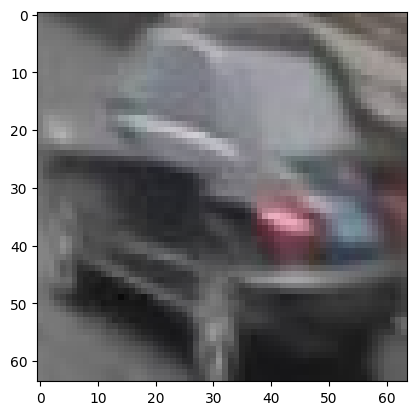

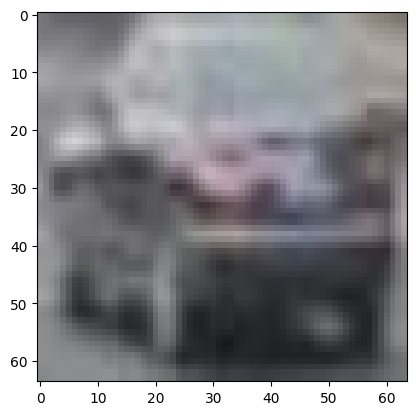

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/1049/MVI_40204_026_img00118.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/1049/MVI_40204_026_img00190.jpg'

predict(path, path2, encoder)

1/1 [==============================] - 0s 103ms/step
0.13299078


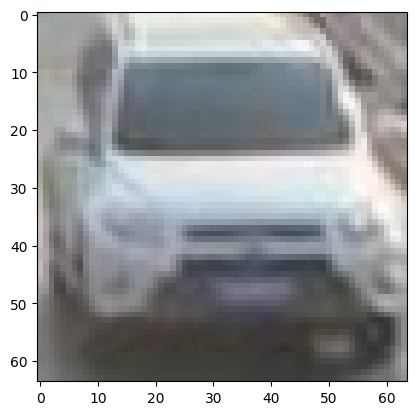

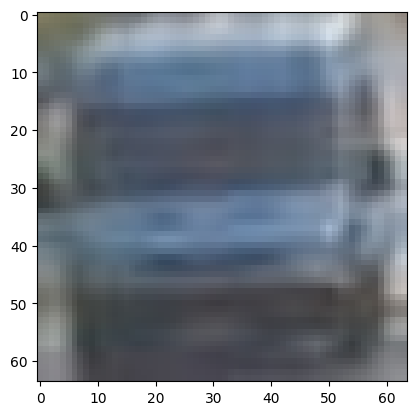

In [ ]:
path = '../input/vehicle-reidentification-in-context/vric/10/MVI_20011_023_img00329.jpg'
path2 = '../input/vehicle-reidentification-in-context/vric/105/MVI_20035_043_img00103.jpg'

predict(path, path2, encoder)